# Recurrent Neural Network

In [19]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


def union(df1, df2):
    return pd.concat([df1, df2]).drop_duplicates().reset_index(drop=True)


def load_data(column, batch_size):
    # Load data
    train = pd.read_csv("Google_Stock_Price_Train.csv", parse_dates=["Date"], thousands=',')
    test = pd.read_csv("Google_Stock_Price_Test.csv", parse_dates=["Date"], thousands=',')

    # Merge training and testing and apply one hot encoding
    data = union(train, test)
    # Add month and day
    data["month"] = pd.DatetimeIndex(data["Date"]).month
    data["day"] = pd.DatetimeIndex(data["Date"]).day
    data = pd.get_dummies(data, columns=["month", "day"]).drop(columns=["Date"])
    data = data.iloc[565:]

    # Apply min-max scaler
    scaler = MinMaxScaler()
    scaler.fit(data)
    data = pd.DataFrame(scaler.transform(data), columns=data.columns)
    
    y = data[column].to_numpy()
    X = data.drop(columns=column).to_numpy()
    features = X.shape[1]

    # Split training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

    # Convert to tensor
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    X_test = torch.Tensor(X_test)
    y_test = torch.Tensor(y_test)
    X_val = torch.Tensor(X_val)
    y_val = torch.Tensor(y_val)

    train = TensorDataset(X_train, y_train)
    test = TensorDataset(X_test, y_test)
    val = TensorDataset(X_val, y_val)

    trainloader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
    testloader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
    valloader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

    return trainloader, testloader, valloader, features

In [20]:
import torch.nn as nn
import torch.nn.functional as F


def get_model(model, **args):
    if model == "rnn":
        return RNN(**args)
    elif model == "lstm":
        return LSTM(**args)
    elif model == "gru":
        return GRU(**args)

In [21]:
class RNN(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.RNN(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [22]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.LSTM(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [23]:
class GRU(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(GRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.GRU(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [24]:
import numpy as np
import matplotlib.pyplot as plt


def fit(rnn, trainloader, testloader, valloader, batch_size, criterion, optimizer, features):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    rnn.to(device)
    epoch_num = 200
    min_val = 1000
    n = 0
    train_losses = []
    val_losses = []
    for epoch in range(1, epoch_num + 1):  # loop over the dataset multiple times
        batch_losses = []
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.view([batch_size, -1, features]).to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            rnn.train()
            outputs = rnn(inputs)
            loss = criterion(labels, outputs)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_losses.append(np.mean(batch_losses))

        # Validation loss
        with torch.no_grad():
            batch_val_losses = []
            for inputs, labels in valloader:
                # get the inputs; data is a list of [inputs, labels]
                inputs = inputs.view([batch_size, -1, features]).to(device)
                labels = labels.to(device)

                # forward + backward + optimize
                rnn.eval()
                outputs = rnn(inputs)
                loss = criterion(labels, outputs)
                batch_val_losses.append(loss.item())

            val_losses.append(np.mean(batch_val_losses))

        if np.mean(batch_val_losses) < min_val:
            min_val = np.mean(batch_val_losses)
            n = 0
        else:
            n += 1
        if n == 5:
            #print(f"Epoch: {epoch}  Training Error: {np.mean(batch_losses):.4f}  Validation Error: {np.mean(batch_val_losses):.4f}")
            break

        if epoch % 1 == 0:
            print(f"Epoch: {epoch}  Training Error: {np.mean(batch_losses):.4f}  Validation Error: {np.mean(batch_val_losses):.4f}")
    '''
    plt.yscale("log")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.title("Training and validation error of GRU")
    plt.legend(["Training Error", "Validation Error"])
    '''

    train_prediction = []
    train_actual = []
    test_prediction = []
    test_actual = []
    for inputs, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.view([batch_size, -1, features]).to(device)
        labels = labels.to(device)
        
        rnn.eval()
        outputs = rnn(inputs)
        train_prediction.append(outputs.detach().numpy())
        train_actual.append(labels.detach().numpy())

    for inputs, labels in testloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.view([batch_size, -1, features]).to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        rnn.eval()
        outputs = rnn(inputs)
        test_prediction.append(outputs.detach().numpy())
        test_actual.append(labels.detach().numpy())

    train_prediction = np.array(train_prediction).flatten()
    train_actual = np.array(train_actual).flatten()
    test_prediction = np.array(test_prediction).flatten()
    test_actual = np.array(test_actual).flatten()

    return train_prediction, train_actual, test_prediction, test_actual


In [25]:
import seaborn as sns
sns.set()

def plot(prediction, actual):
    df = pd.DataFrame({"Predicted": prediction, "Actual": actual})
    sns.lineplot(data=df)

In [26]:
from sklearn.metrics import mean_squared_error, r2_score

def metrics(prediction, actual):
    r2 = r2_score(actual, prediction)
    rmse = mean_squared_error(actual, prediction, squared=False)

    print(f"R-squared: {r2:.4f}")
    print(f"Mean Square Error: {rmse:.4f}")
    return r2, rmse

In [27]:
import torch.optim as optim
column = "Close"
batch_size = 20

trainloader, testloader, valloader, features = load_data(column, batch_size)

# RNN hyperparamters
params = {"hidden_dim": 200,
        "layer_dim": 1,
        "dropout": 0.2,
        "features": features}

# rnn, lstm, gru
model = "rnn"
r2_scores = []
rmse_scores = []
for i in range(100):
        rnn = get_model(model, **params)

        criterion = nn.MSELoss(reduction="mean")
        optimizer = optim.Adam(rnn.parameters(), lr=0.001)

        args = {"batch_size": batch_size,
                "trainloader": trainloader,
                "testloader": testloader,
                "valloader": valloader,
                "features": features,
                "rnn": rnn,
                "criterion": criterion,
                "optimizer": optimizer}

        train_prediction, train_actual, test_prediction, test_actual = fit(**args)
        r2, rmse = metrics(test_prediction, test_actual)
        r2_scores.append(r2)
        rmse_scores.append(rmse)


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0357  Validation Error: 0.0032
Epoch: 2  Training Error: 0.0570  Validation Error: 0.0071
Epoch: 3  Training Error: 0.0164  Validation Error: 0.0037
Epoch: 4  Training Error: 0.0053  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0040
R-squared: 0.6635
Mean Square Error: 0.0217
Epoch: 1  Training Error: 0.0481  Validation Error: 0.0111
Epoch: 2  Training Error: 0.0636  Validation Error: 0.0249


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0159  Validation Error: 0.0048
Epoch: 4  Training Error: 0.0067  Validation Error: 0.0033
Epoch: 5  Training Error: 0.0045  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.7787
Mean Square Error: 0.0176
Epoch: 1  Training Error: 0.0447  Validation Error: 0.0055
Epoch: 2  Training Error: 0.0670  Validation Error: 0.0193
Epoch: 3  Training Error: 0.0168  Validation Error: 0.0045


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0062  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7537
Mean Square Error: 0.0186
Epoch: 1  Training Error: 0.0364  Validation Error: 0.0041
Epoch: 2  Training Error: 0.0609  Validation Error: 0.0088
Epoch: 3  Training Error: 0.0168  Validation Error: 0.0042


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0053  Validation Error: 0.0040
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 9  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 10  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 11  Training Error: 0.0043  Validation Error: 0.0041
R-squared: 0.6228
Mean Square Error: 0.0230
Epoch: 1  Training Error: 0.0343  Validation Error: 0.0060
Epoch: 2  Training Error: 0.0747  Validation Error: 0.0097
Epoch: 3  Training Error: 0.0205  Validation Error: 0.0039


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0060  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7683
Mean Square Error: 0.0180
Epoch: 1  Training Error: 0.0471  Validation Error: 0.0069
Epoch: 2  Training Error: 0.0599  Validation Error: 0.0192
Epoch: 3  Training Error: 0.0138  Validation Error: 0.0044
Epoch: 4  Training Error: 0.0057  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7221
Mean Square Error: 0.0197


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0449  Validation Error: 0.0060
Epoch: 2  Training Error: 0.0632  Validation Error: 0.0169
Epoch: 3  Training Error: 0.0152  Validation Error: 0.0042
Epoch: 4  Training Error: 0.0057  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7259
Mean Square Error: 0.0196
Epoch: 1  Training Error: 0.0362  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0549  Validation Error: 0.0080
Epoch: 3  Training Error: 0.0151  Validation Error: 0.0040
Epoch: 4  Training Error: 0.0052  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0040
R-squared: 0.7538
Mean Square Error: 0.0185


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0371  Validation Error: 0.0038
Epoch: 2  Training Error: 0.0581  Validation Error: 0.0085
Epoch: 3  Training Error: 0.0163  Validation Error: 0.0040
Epoch: 4  Training Error: 0.0054  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0040
R-squared: 0.7699
Mean Square Error: 0.0179
Epoch: 1  Training Error: 0.0483  Validation Error: 0.0077
Epoch: 2  Training Error: 0.0620  Validation Error: 0.0181
Epoch: 3  Training Error: 0.0154  Validation Error: 0.0038
Epoch: 4  Training Error: 0.0061  Validation Error: 0.0034


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0044  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7250
Mean Square Error: 0.0196
Epoch: 1  Training Error: 0.0428  Validation Error: 0.0081
Epoch: 2  Training Error: 0.0591  Validation Error: 0.0172
Epoch: 3  Training Error: 0.0144  Validation Error: 0.0043
Epoch: 4  Training Error: 0.0053  Validation Error: 0.0037


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0043  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7479
Mean Square Error: 0.0188


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0536  Validation Error: 0.0169
Epoch: 2  Training Error: 0.0666  Validation Error: 0.0296
Epoch: 3  Training Error: 0.0179  Validation Error: 0.0064
Epoch: 4  Training Error: 0.0080  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0048  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.7958
Mean Square Error: 0.0169
Epoch: 1  Training Error: 0.0506  Validation Error: 0.0070


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0697  Validation Error: 0.0247
Epoch: 3  Training Error: 0.0159  Validation Error: 0.0050
Epoch: 4  Training Error: 0.0066  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0045  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
R-squared: 0.7405
Mean Square Error: 0.0190
Epoch: 1  Training Error: 0.0373  Validation Error: 0.0037


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0584  Validation Error: 0.0113
Epoch: 3  Training Error: 0.0142  Validation Error: 0.0037
Epoch: 4  Training Error: 0.0050  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0039
R-squared: 0.7786
Mean Square Error: 0.0176
Epoch: 1  Training Error: 0.0291  Validation Error: 0.0055
Epoch: 2  Training Error: 0.0552  Validation Error: 0.0050
Epoch: 3  Training Error: 0.0163  Validation Error: 0.0038
Epoch: 4  Training Error: 0.0050  Validation Error: 0.0039


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0044  Validation Error: 0.0040
Epoch: 6  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 9  Training Error: 0.0043  Validation Error: 0.0040
Epoch: 10  Training Error: 0.0043  Validation Error: 0.0040
R-squared: 0.6868
Mean Square Error: 0.0209
Epoch: 1  Training Error: 0.0438  Validation Error: 0.0056
Epoch: 2  Training Error: 0.0683  Validation Error: 0.0188


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0163  Validation Error: 0.0047
Epoch: 4  Training Error: 0.0058  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7856
Mean Square Error: 0.0173
Epoch: 1  Training Error: 0.0350  Validation Error: 0.0035
Epoch: 2  Training Error: 0.0560  Validation Error: 0.0086
Epoch: 3  Training Error: 0.0152  Validation Error: 0.0041


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0052  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0041
R-squared: 0.6867
Mean Square Error: 0.0209
Epoch: 1  Training Error: 0.0388  Validation Error: 0.0042
Epoch: 2  Training Error: 0.0550  Validation Error: 0.0083


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0142  Validation Error: 0.0041
Epoch: 4  Training Error: 0.0050  Validation Error: 0.0040
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0041
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 10  Training Error: 0.0043  Validation Error: 0.0040
Epoch: 11  Training Error: 0.0043  Validation Error: 0.0040
R-squared: 0.6722
Mean Square Error: 0.0214


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0485  Validation Error: 0.0064
Epoch: 2  Training Error: 0.0598  Validation Error: 0.0158
Epoch: 3  Training Error: 0.0132  Validation Error: 0.0038
Epoch: 4  Training Error: 0.0055  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7507
Mean Square Error: 0.0187
Epoch: 1  Training Error: 0.0506  Validation Error: 0.0061


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0711  Validation Error: 0.0244
Epoch: 3  Training Error: 0.0178  Validation Error: 0.0046
Epoch: 4  Training Error: 0.0082  Validation Error: 0.0034
Epoch: 5  Training Error: 0.0050  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
R-squared: 0.7425
Mean Square Error: 0.0190
Epoch: 1  Training Error: 0.0349  Validation Error: 0.0039
Epoch: 2  Training Error: 0.0570  Validation Error: 0.0079


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0145  Validation Error: 0.0041
Epoch: 4  Training Error: 0.0048  Validation Error: 0.0040
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0040
Epoch: 6  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 8  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 9  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 10  Training Error: 0.0043  Validation Error: 0.0041
R-squared: 0.6682
Mean Square Error: 0.0215
Epoch: 1  Training Error: 0.0360  Validation Error: 0.0032
Epoch: 2  Training Error: 0.0566  Validation Error: 0.0075
Epoch: 3  Training Error: 0.0150  Validation Error: 0.0039
Epoch: 4  Training Error: 0.0050  Validation Error: 0.0040


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0043  Validation Error: 0.0041
R-squared: 0.7987
Mean Square Error: 0.0168
Epoch: 1  Training Error: 0.0361  Validation Error: 0.0046
Epoch: 2  Training Error: 0.0516  Validation Error: 0.0083


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0136  Validation Error: 0.0042
Epoch: 4  Training Error: 0.0047  Validation Error: 0.0041
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0042
Epoch: 6  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 8  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 9  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 10  Training Error: 0.0043  Validation Error: 0.0041
R-squared: 0.6576
Mean Square Error: 0.0219
Epoch: 1  Training Error: 0.0387  Validation Error: 0.0030


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0595  Validation Error: 0.0114
Epoch: 3  Training Error: 0.0148  Validation Error: 0.0038
Epoch: 4  Training Error: 0.0052  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0039
R-squared: 0.7543
Mean Square Error: 0.0185


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0319  Validation Error: 0.0058
Epoch: 2  Training Error: 0.0694  Validation Error: 0.0084
Epoch: 3  Training Error: 0.0213  Validation Error: 0.0041
Epoch: 4  Training Error: 0.0061  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0045  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.7596
Mean Square Error: 0.0183
Epoch: 1  Training Error: 0.0339  Validation Error: 0.0046


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0541  Validation Error: 0.0098
Epoch: 3  Training Error: 0.0154  Validation Error: 0.0049
Epoch: 4  Training Error: 0.0051  Validation Error: 0.0044
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0044
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0040
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 9  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 10  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 11  Training Error: 0.0043  Validation Error: 0.0041
R-squared: 0.6296
Mean Square Error: 0.0227
Epoch: 1  Training Error: 0.0551  Validation Error: 0.0146
Epoch: 2  Training Error: 0.0649  Validation Error: 0.0279
Epoch: 3  Training Error: 0.0165  Validation Error: 0.0056
Epoch: 4  Training Error: 0.0076  Validation Error: 0.0033


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0048  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.7731
Mean Square Error: 0.0178


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0469  Validation Error: 0.0051
Epoch: 2  Training Error: 0.0641  Validation Error: 0.0177
Epoch: 3  Training Error: 0.0152  Validation Error: 0.0044
Epoch: 4  Training Error: 0.0059  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0040
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7511
Mean Square Error: 0.0186


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0507  Validation Error: 0.0070
Epoch: 2  Training Error: 0.0658  Validation Error: 0.0199
Epoch: 3  Training Error: 0.0157  Validation Error: 0.0041
Epoch: 4  Training Error: 0.0069  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0047  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8004
Mean Square Error: 0.0167
Epoch: 1  Training Error: 0.0573  Validation Error: 0.0145


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0707  Validation Error: 0.0342
Epoch: 3  Training Error: 0.0161  Validation Error: 0.0069
Epoch: 4  Training Error: 0.0075  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0047  Validation Error: 0.0040
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
R-squared: 0.7418
Mean Square Error: 0.0190


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0498  Validation Error: 0.0087
Epoch: 2  Training Error: 0.0602  Validation Error: 0.0192
Epoch: 3  Training Error: 0.0138  Validation Error: 0.0044
Epoch: 4  Training Error: 0.0057  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7657
Mean Square Error: 0.0181
Epoch: 1  Training Error: 0.0598  Validation Error: 0.0131


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0651  Validation Error: 0.0280
Epoch: 3  Training Error: 0.0158  Validation Error: 0.0051
Epoch: 4  Training Error: 0.0075  Validation Error: 0.0034
Epoch: 5  Training Error: 0.0047  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7286
Mean Square Error: 0.0195
Epoch: 1  Training Error: 0.0373  Validation Error: 0.0040
Epoch: 2  Training Error: 0.0627  Validation Error: 0.0145


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0163  Validation Error: 0.0038
Epoch: 4  Training Error: 0.0057  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7460
Mean Square Error: 0.0188
Epoch: 1  Training Error: 0.0452  Validation Error: 0.0081
Epoch: 2  Training Error: 0.0590  Validation Error: 0.0175
Epoch: 3  Training Error: 0.0145  Validation Error: 0.0045


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0058  Validation Error: 0.0040
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0041
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0041
Epoch: 10  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 11  Training Error: 0.0043  Validation Error: 0.0041
R-squared: 0.6201
Mean Square Error: 0.0230
Epoch: 1  Training Error: 0.0388  Validation Error: 0.0037


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0674  Validation Error: 0.0142
Epoch: 3  Training Error: 0.0177  Validation Error: 0.0043
Epoch: 4  Training Error: 0.0063  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0045  Validation Error: 0.0039
R-squared: 0.5889
Mean Square Error: 0.0240
Epoch: 1  Training Error: 0.0524  Validation Error: 0.0125
Epoch: 2  Training Error: 0.0665  Validation Error: 0.0239
Epoch: 3  Training Error: 0.0165  Validation Error: 0.0050
Epoch: 4  Training Error: 0.0070  Validation Error: 0.0036


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0047  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7690
Mean Square Error: 0.0180


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0474  Validation Error: 0.0119
Epoch: 2  Training Error: 0.0583  Validation Error: 0.0207
Epoch: 3  Training Error: 0.0155  Validation Error: 0.0043
Epoch: 4  Training Error: 0.0065  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0045  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7333
Mean Square Error: 0.0193
Epoch: 1  Training Error: 0.0504  Validation Error: 0.0130
Epoch: 2  Training Error: 0.0654  Validation Error: 0.0259
Epoch: 3  Training Error: 0.0165  Validation Error: 0.0049


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0071  Validation Error: 0.0033
Epoch: 5  Training Error: 0.0046  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7418
Mean Square Error: 0.0190
Epoch: 1  Training Error: 0.0411  Validation Error: 0.0042
Epoch: 2  Training Error: 0.0580  Validation Error: 0.0136


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0140  Validation Error: 0.0045
Epoch: 4  Training Error: 0.0051  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0040
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 11  Training Error: 0.0043  Validation Error: 0.0040
R-squared: 0.6863
Mean Square Error: 0.0209
Epoch: 1  Training Error: 0.0430  Validation Error: 0.0040
Epoch: 2  Training Error: 0.0608  Validation Error: 0.0133


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0149  Validation Error: 0.0039
Epoch: 4  Training Error: 0.0056  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7582
Mean Square Error: 0.0184
Epoch: 1  Training Error: 0.0570  Validation Error: 0.0128


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0650  Validation Error: 0.0268
Epoch: 3  Training Error: 0.0165  Validation Error: 0.0049
Epoch: 4  Training Error: 0.0080  Validation Error: 0.0033
Epoch: 5  Training Error: 0.0049  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.7628
Mean Square Error: 0.0182
Epoch: 1  Training Error: 0.0423  Validation Error: 0.0038


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0694  Validation Error: 0.0184
Epoch: 3  Training Error: 0.0176  Validation Error: 0.0044
Epoch: 4  Training Error: 0.0066  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0045  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
R-squared: 0.7700
Mean Square Error: 0.0179


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0393  Validation Error: 0.0034
Epoch: 2  Training Error: 0.0579  Validation Error: 0.0088
Epoch: 3  Training Error: 0.0137  Validation Error: 0.0037
Epoch: 4  Training Error: 0.0048  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0039
R-squared: 0.7818
Mean Square Error: 0.0175
Epoch: 1  Training Error: 0.0325  Validation Error: 0.0035
Epoch: 2  Training Error: 0.0561  Validation Error: 0.0076
Epoch: 3  Training Error: 0.0163  Validation Error: 0.0041


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0052  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0039
R-squared: 0.7707
Mean Square Error: 0.0179
Epoch: 1  Training Error: 0.0365  Validation Error: 0.0031


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0694  Validation Error: 0.0143
Epoch: 3  Training Error: 0.0181  Validation Error: 0.0041
Epoch: 4  Training Error: 0.0059  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0037
R-squared: 0.7707
Mean Square Error: 0.0179
Epoch: 1  Training Error: 0.0321  Validation Error: 0.0060
Epoch: 2  Training Error: 0.0628  Validation Error: 0.0055
Epoch: 3  Training Error: 0.0184  Validation Error: 0.0040


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0053  Validation Error: 0.0040
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0041
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 11  Training Error: 0.0042  Validation Error: 0.0040
R-squared: 0.6835
Mean Square Error: 0.0210


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0660  Validation Error: 0.0283
Epoch: 2  Training Error: 0.0715  Validation Error: 0.0392
Epoch: 3  Training Error: 0.0183  Validation Error: 0.0077
Epoch: 4  Training Error: 0.0087  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0049  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
R-squared: 0.7224
Mean Square Error: 0.0197
Epoch: 1  Training Error: 0.0307  Validation Error: 0.0044
Epoch: 2  Training Error: 0.0645  Validation Error: 0.0096
Epoch: 3  Training Error: 0.0181  Validation Error: 0.0039
Epoch: 4  Training Error: 0.0054  Validation Error: 0.0037


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7638
Mean Square Error: 0.0182
Epoch: 1  Training Error: 0.0542  Validation Error: 0.0086
Epoch: 2  Training Error: 0.0696  Validation Error: 0.0241
Epoch: 3  Training Error: 0.0152  Validation Error: 0.0043


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0068  Validation Error: 0.0033
Epoch: 5  Training Error: 0.0046  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7511
Mean Square Error: 0.0186
Epoch: 1  Training Error: 0.0342  Validation Error: 0.0038
Epoch: 2  Training Error: 0.0610  Validation Error: 0.0065


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0178  Validation Error: 0.0036
Epoch: 4  Training Error: 0.0054  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.7954
Mean Square Error: 0.0169
Epoch: 1  Training Error: 0.0497  Validation Error: 0.0066
Epoch: 2  Training Error: 0.0644  Validation Error: 0.0208
Epoch: 3  Training Error: 0.0147  Validation Error: 0.0046


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0062  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7521
Mean Square Error: 0.0186
Epoch: 1  Training Error: 0.0465  Validation Error: 0.0070
Epoch: 2  Training Error: 0.0593  Validation Error: 0.0169
Epoch: 3  Training Error: 0.0135  Validation Error: 0.0043


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0053  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7215
Mean Square Error: 0.0197
Epoch: 1  Training Error: 0.0314  Validation Error: 0.0042
Epoch: 2  Training Error: 0.0579  Validation Error: 0.0056


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0171  Validation Error: 0.0039
Epoch: 4  Training Error: 0.0050  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 6  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 9  Training Error: 0.0043  Validation Error: 0.0040
Epoch: 10  Training Error: 0.0043  Validation Error: 0.0040
R-squared: 0.7003
Mean Square Error: 0.0205
Epoch: 1  Training Error: 0.0359  Validation Error: 0.0038
Epoch: 2  Training Error: 0.0538  Validation Error: 0.0096
Epoch: 3  Training Error: 0.0139  Validation Error: 0.0040
Epoch: 4  Training Error: 0.0050  Validation Error: 0.0037


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0043  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7422
Mean Square Error: 0.0190


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0395  Validation Error: 0.0041
Epoch: 2  Training Error: 0.0655  Validation Error: 0.0164
Epoch: 3  Training Error: 0.0165  Validation Error: 0.0050
Epoch: 4  Training Error: 0.0058  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7973
Mean Square Error: 0.0168
Epoch: 1  Training Error: 0.0430  Validation Error: 0.0041
Epoch: 2  Training Error: 0.0577  Validation Error: 0.0114
Epoch: 3  Training Error: 0.0137  Validation Error: 0.0041
Epoch: 4  Training Error: 0.0049  Validation Error: 0.0039


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 6  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0040
R-squared: 0.6704
Mean Square Error: 0.0215
Epoch: 1  Training Error: 0.0335  Validation Error: 0.0030
Epoch: 2  Training Error: 0.0556  Validation Error: 0.0074
Epoch: 3  Training Error: 0.0157  Validation Error: 0.0037
Epoch: 4  Training Error: 0.0051  Validation Error: 0.0037


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0043  Validation Error: 0.0039
R-squared: 0.7735
Mean Square Error: 0.0178
Epoch: 1  Training Error: 0.0367  Validation Error: 0.0028
Epoch: 2  Training Error: 0.0526  Validation Error: 0.0067
Epoch: 3  Training Error: 0.0136  Validation Error: 0.0036


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0048  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0039
R-squared: 0.8020
Mean Square Error: 0.0166
Epoch: 1  Training Error: 0.0360  Validation Error: 0.0030
Epoch: 2  Training Error: 0.0537  Validation Error: 0.0069


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0143  Validation Error: 0.0038
Epoch: 4  Training Error: 0.0049  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0041
R-squared: 0.7629
Mean Square Error: 0.0182


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0343  Validation Error: 0.0031
Epoch: 2  Training Error: 0.0519  Validation Error: 0.0054
Epoch: 3  Training Error: 0.0134  Validation Error: 0.0036
Epoch: 4  Training Error: 0.0048  Validation Error: 0.0040
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0041
R-squared: 0.8011
Mean Square Error: 0.0167
Epoch: 1  Training Error: 0.0531  Validation Error: 0.0059
Epoch: 2  Training Error: 0.0712  Validation Error: 0.0240
Epoch: 3  Training Error: 0.0161  Validation Error: 0.0045
Epoch: 4  Training Error: 0.0072  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0047  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
R-squared: 0.7708
Mean Square Error: 0.0179


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0543  Validation Error: 0.0126
Epoch: 2  Training Error: 0.0680  Validation Error: 0.0311
Epoch: 3  Training Error: 0.0160  Validation Error: 0.0060
Epoch: 4  Training Error: 0.0075  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0048  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
R-squared: 0.7814
Mean Square Error: 0.0175
Epoch: 1  Training Error: 0.0400  Validation Error: 0.0054


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0683  Validation Error: 0.0198
Epoch: 3  Training Error: 0.0176  Validation Error: 0.0044
Epoch: 4  Training Error: 0.0064  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0045  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7600
Mean Square Error: 0.0183
Epoch: 1  Training Error: 0.0466  Validation Error: 0.0062


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0628  Validation Error: 0.0171
Epoch: 3  Training Error: 0.0155  Validation Error: 0.0045
Epoch: 4  Training Error: 0.0059  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7411
Mean Square Error: 0.0190


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0389  Validation Error: 0.0044
Epoch: 2  Training Error: 0.0734  Validation Error: 0.0153
Epoch: 3  Training Error: 0.0199  Validation Error: 0.0046
Epoch: 4  Training Error: 0.0063  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7584
Mean Square Error: 0.0184
Epoch: 1  Training Error: 0.0422  Validation Error: 0.0037
Epoch: 2  Training Error: 0.0699  Validation Error: 0.0150
Epoch: 3  Training Error: 0.0181  Validation Error: 0.0040


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0063  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0038
R-squared: 0.7340
Mean Square Error: 0.0193
Epoch: 1  Training Error: 0.0390  Validation Error: 0.0037
Epoch: 2  Training Error: 0.0570  Validation Error: 0.0100


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0142  Validation Error: 0.0038
Epoch: 4  Training Error: 0.0050  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7253
Mean Square Error: 0.0196
Epoch: 1  Training Error: 0.0445  Validation Error: 0.0050
Epoch: 2  Training Error: 0.0644  Validation Error: 0.0177


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0152  Validation Error: 0.0044
Epoch: 4  Training Error: 0.0059  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0045  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.7725
Mean Square Error: 0.0178
Epoch: 1  Training Error: 0.0549  Validation Error: 0.0118


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0685  Validation Error: 0.0257
Epoch: 3  Training Error: 0.0161  Validation Error: 0.0049
Epoch: 4  Training Error: 0.0072  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0047  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7598
Mean Square Error: 0.0183
Epoch: 1  Training Error: 0.0559  Validation Error: 0.0164
Epoch: 2  Training Error: 0.0667  Validation Error: 0.0278


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0167  Validation Error: 0.0053
Epoch: 4  Training Error: 0.0074  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0047  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7909
Mean Square Error: 0.0171
Epoch: 1  Training Error: 0.0465  Validation Error: 0.0112
Epoch: 2  Training Error: 0.0709  Validation Error: 0.0284
Epoch: 3  Training Error: 0.0186  Validation Error: 0.0051


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0078  Validation Error: 0.0033
Epoch: 5  Training Error: 0.0048  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.7652
Mean Square Error: 0.0181
Epoch: 1  Training Error: 0.0610  Validation Error: 0.0230
Epoch: 2  Training Error: 0.0715  Validation Error: 0.0344
Epoch: 3  Training Error: 0.0183  Validation Error: 0.0058
Epoch: 4  Training Error: 0.0081  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0047  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
R-squared: 0.7230
Mean Square Error: 0.0197


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0361  Validation Error: 0.0029
Epoch: 2  Training Error: 0.0595  Validation Error: 0.0109
Epoch: 3  Training Error: 0.0155  Validation Error: 0.0038
Epoch: 4  Training Error: 0.0053  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0038
R-squared: 0.7361
Mean Square Error: 0.0192
Epoch: 1  Training Error: 0.0388  Validation Error: 0.0035
Epoch: 2  Training Error: 0.0569  Validation Error: 0.0094
Epoch: 3  Training Error: 0.0142  Validation Error: 0.0036
Epoch: 4  Training Error: 0.0049  Validation Error: 0.0037


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0043  Validation Error: 0.0039
R-squared: 0.7794
Mean Square Error: 0.0176
Epoch: 1  Training Error: 0.0327  Validation Error: 0.0052
Epoch: 2  Training Error: 0.0643  Validation Error: 0.0067
Epoch: 3  Training Error: 0.0187  Validation Error: 0.0040


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0053  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7704
Mean Square Error: 0.0179
Epoch: 1  Training Error: 0.0518  Validation Error: 0.0153
Epoch: 2  Training Error: 0.0590  Validation Error: 0.0242
Epoch: 3  Training Error: 0.0152  Validation Error: 0.0048
Epoch: 4  Training Error: 0.0070  Validation Error: 0.0034


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0046  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7668
Mean Square Error: 0.0181


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0406  Validation Error: 0.0048
Epoch: 2  Training Error: 0.0669  Validation Error: 0.0202
Epoch: 3  Training Error: 0.0179  Validation Error: 0.0046
Epoch: 4  Training Error: 0.0069  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0046  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.7812
Mean Square Error: 0.0175
Epoch: 1  Training Error: 0.0297  Validation Error: 0.0052


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0577  Validation Error: 0.0060
Epoch: 3  Training Error: 0.0176  Validation Error: 0.0039
Epoch: 4  Training Error: 0.0052  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0040
Epoch: 6  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0041
Epoch: 10  Training Error: 0.0043  Validation Error: 0.0041
R-squared: 0.6786
Mean Square Error: 0.0212


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0328  Validation Error: 0.0036
Epoch: 2  Training Error: 0.0580  Validation Error: 0.0057
Epoch: 3  Training Error: 0.0160  Validation Error: 0.0037
Epoch: 4  Training Error: 0.0049  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0040
R-squared: 0.7770
Mean Square Error: 0.0177
Epoch: 1  Training Error: 0.0388  Validation Error: 0.0056
Epoch: 2  Training Error: 0.0606  Validation Error: 0.0146
Epoch: 3  Training Error: 0.0142  Validation Error: 0.0041
Epoch: 4  Training Error: 0.0050  Validation Error: 0.0039


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0043  Validation Error: 0.0040
Epoch: 6  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0040
R-squared: 0.7258
Mean Square Error: 0.0196


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0511  Validation Error: 0.0096
Epoch: 2  Training Error: 0.0651  Validation Error: 0.0220
Epoch: 3  Training Error: 0.0161  Validation Error: 0.0046
Epoch: 4  Training Error: 0.0068  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0046  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
R-squared: 0.7508
Mean Square Error: 0.0187
Epoch: 1  Training Error: 0.0538  Validation Error: 0.0149


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0639  Validation Error: 0.0279
Epoch: 3  Training Error: 0.0156  Validation Error: 0.0052
Epoch: 4  Training Error: 0.0071  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0046  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7471
Mean Square Error: 0.0188
Epoch: 1  Training Error: 0.0365  Validation Error: 0.0032


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0595  Validation Error: 0.0058
Epoch: 3  Training Error: 0.0162  Validation Error: 0.0039
Epoch: 4  Training Error: 0.0050  Validation Error: 0.0040
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0041
R-squared: 0.6886
Mean Square Error: 0.0209
Epoch: 1  Training Error: 0.0474  Validation Error: 0.0068
Epoch: 2  Training Error: 0.0618  Validation Error: 0.0175
Epoch: 3  Training Error: 0.0149  Validation Error: 0.0040
Epoch: 4  Training Error: 0.0061  Validation Error: 0.0034


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0045  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.7787
Mean Square Error: 0.0176
Epoch: 1  Training Error: 0.0330  Validation Error: 0.0038
Epoch: 2  Training Error: 0.0649  Validation Error: 0.0074
Epoch: 3  Training Error: 0.0186  Validation Error: 0.0036
Epoch: 4  Training Error: 0.0053  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7361
Mean Square Error: 0.0192


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0348  Validation Error: 0.0033
Epoch: 2  Training Error: 0.0680  Validation Error: 0.0117
Epoch: 3  Training Error: 0.0194  Validation Error: 0.0042
Epoch: 4  Training Error: 0.0063  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0045  Validation Error: 0.0038
R-squared: 0.6492
Mean Square Error: 0.0221
Epoch: 1  Training Error: 0.0362  Validation Error: 0.0034
Epoch: 2  Training Error: 0.0666  Validation Error: 0.0126
Epoch: 3  Training Error: 0.0177  Validation Error: 0.0039
Epoch: 4  Training Error: 0.0060  Validation Error: 0.0036


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0044  Validation Error: 0.0038
R-squared: 0.7719
Mean Square Error: 0.0179
Epoch: 1  Training Error: 0.0341  Validation Error: 0.0035
Epoch: 2  Training Error: 0.0578  Validation Error: 0.0059
Epoch: 3  Training Error: 0.0168  Validation Error: 0.0038


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0052  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0040
R-squared: 0.6349
Mean Square Error: 0.0226
Epoch: 1  Training Error: 0.0359  Validation Error: 0.0039
Epoch: 2  Training Error: 0.0625  Validation Error: 0.0110


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0177  Validation Error: 0.0043
Epoch: 4  Training Error: 0.0058  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7161
Mean Square Error: 0.0199
Epoch: 1  Training Error: 0.0429  Validation Error: 0.0032
Epoch: 2  Training Error: 0.0645  Validation Error: 0.0120
Epoch: 3  Training Error: 0.0154  Validation Error: 0.0038


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0054  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0038
R-squared: 0.6762
Mean Square Error: 0.0213
Epoch: 1  Training Error: 0.0408  Validation Error: 0.0040
Epoch: 2  Training Error: 0.0680  Validation Error: 0.0162


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0176  Validation Error: 0.0043
Epoch: 4  Training Error: 0.0063  Validation Error: 0.0034
Epoch: 5  Training Error: 0.0045  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.7787
Mean Square Error: 0.0176
Epoch: 1  Training Error: 0.0391  Validation Error: 0.0033
Epoch: 2  Training Error: 0.0631  Validation Error: 0.0130
Epoch: 3  Training Error: 0.0163  Validation Error: 0.0037


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0058  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0036
R-squared: 0.7182
Mean Square Error: 0.0198
Epoch: 1  Training Error: 0.0304  Validation Error: 0.0070


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0635  Validation Error: 0.0051
Epoch: 3  Training Error: 0.0197  Validation Error: 0.0037
Epoch: 4  Training Error: 0.0055  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7567
Mean Square Error: 0.0184
Epoch: 1  Training Error: 0.0441  Validation Error: 0.0070
Epoch: 2  Training Error: 0.0568  Validation Error: 0.0165


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0132  Validation Error: 0.0043
Epoch: 4  Training Error: 0.0054  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7341
Mean Square Error: 0.0193
Epoch: 1  Training Error: 0.0353  Validation Error: 0.0043
Epoch: 2  Training Error: 0.0522  Validation Error: 0.0081
Epoch: 3  Training Error: 0.0135  Validation Error: 0.0046


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0048  Validation Error: 0.0044
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0043
Epoch: 6  Training Error: 0.0041  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 8  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 9  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 10  Training Error: 0.0043  Validation Error: 0.0041
R-squared: 0.6288
Mean Square Error: 0.0228
Epoch: 1  Training Error: 0.0389  Validation Error: 0.0029


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0605  Validation Error: 0.0102
Epoch: 3  Training Error: 0.0152  Validation Error: 0.0036
Epoch: 4  Training Error: 0.0053  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0043  Validation Error: 0.0038
R-squared: 0.7762
Mean Square Error: 0.0177
Epoch: 1  Training Error: 0.0472  Validation Error: 0.0060
Epoch: 2  Training Error: 0.0669  Validation Error: 0.0206
Epoch: 3  Training Error: 0.0160  Validation Error: 0.0046
Epoch: 4  Training Error: 0.0066  Validation Error: 0.0036


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0046  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7193
Mean Square Error: 0.0198


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0553  Validation Error: 0.0165
Epoch: 2  Training Error: 0.0612  Validation Error: 0.0261
Epoch: 3  Training Error: 0.0150  Validation Error: 0.0049
Epoch: 4  Training Error: 0.0069  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0045  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7528
Mean Square Error: 0.0186
Epoch: 1  Training Error: 0.0378  Validation Error: 0.0033


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0709  Validation Error: 0.0133
Epoch: 3  Training Error: 0.0186  Validation Error: 0.0045
Epoch: 4  Training Error: 0.0059  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0044  Validation Error: 0.0039
R-squared: 0.7326
Mean Square Error: 0.0193
Epoch: 1  Training Error: 0.0494  Validation Error: 0.0067
Epoch: 2  Training Error: 0.0628  Validation Error: 0.0166
Epoch: 3  Training Error: 0.0139  Validation Error: 0.0040
Epoch: 4  Training Error: 0.0059  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0045  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.7567
Mean Square Error: 0.0184


In [33]:
import torch.optim as optim
column = "Close"
batch_size = 20

trainloader, testloader, valloader, features = load_data(column, batch_size)

# RNN hyperparamters
params = {"hidden_dim": 100,
        "layer_dim": 1,
        "dropout": 0.2,
        "features": features}

# rnn, lstm, gru
model = "rnn"
r2_scores2 = []
rmse_scores2 = []
for i in range(100):
        rnn = get_model(model, **params)

        criterion = nn.MSELoss(reduction="mean")
        optimizer = optim.Adam(rnn.parameters(), lr=0.001)

        args = {"batch_size": batch_size,
                "trainloader": trainloader,
                "testloader": testloader,
                "valloader": valloader,
                "features": features,
                "rnn": rnn,
                "criterion": criterion,
                "optimizer": optimizer}

        train_prediction, train_actual, test_prediction, test_actual = fit(**args)
        r2, rmse = metrics(test_prediction, test_actual)
        r2_scores2.append(r2)
        rmse_scores2.append(rmse)

C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0350  Validation Error: 0.0038
Epoch: 2  Training Error: 0.0770  Validation Error: 0.0291
Epoch: 3  Training Error: 0.0212  Validation Error: 0.0073
Epoch: 4  Training Error: 0.0104  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0059  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0037
R-squared: 0.7973
Mean Square Error: 0.0168
Epoch: 1  Training Error: 0.0318  Validation Error: 0.0065
Epoch: 2  Training Error: 0.0560  Validation Error: 0.0202


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0158  Validation Error: 0.0053
Epoch: 4  Training Error: 0.0077  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0050  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8284
Mean Square Error: 0.0155
Epoch: 1  Training Error: 0.0381  Validation Error: 0.0158
Epoch: 2  Training Error: 0.0545  Validation Error: 0.0237
Epoch: 3  Training Error: 0.0155  Validation Error: 0.0054
Epoch: 4  Training Error: 0.0080  Validation Error: 0.0034


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0050  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8127
Mean Square Error: 0.0162
Epoch: 1  Training Error: 0.0306  Validation Error: 0.0052


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0600  Validation Error: 0.0232
Epoch: 3  Training Error: 0.0176  Validation Error: 0.0057
Epoch: 4  Training Error: 0.0092  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0054  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8156
Mean Square Error: 0.0161
Epoch: 1  Training Error: 0.0418  Validation Error: 0.0234
Epoch: 2  Training Error: 0.0621  Validation Error: 0.0372


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0204  Validation Error: 0.0100
Epoch: 4  Training Error: 0.0114  Validation Error: 0.0042
Epoch: 5  Training Error: 0.0061  Validation Error: 0.0034
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8239
Mean Square Error: 0.0157
Epoch: 1  Training Error: 0.0437  Validation Error: 0.0169
Epoch: 2  Training Error: 0.0565  Validation Error: 0.0242
Epoch: 3  Training Error: 0.0184  Validation Error: 0.0058
Epoch: 4  Training Error: 0.0103  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0055  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8013
Mean Square Error: 0.0167


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0406  Validation Error: 0.0179
Epoch: 2  Training Error: 0.0620  Validation Error: 0.0344
Epoch: 3  Training Error: 0.0219  Validation Error: 0.0098
Epoch: 4  Training Error: 0.0131  Validation Error: 0.0044
Epoch: 5  Training Error: 0.0069  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0047  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8094
Mean Square Error: 0.0163


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0423  Validation Error: 0.0260
Epoch: 2  Training Error: 0.0524  Validation Error: 0.0300
Epoch: 3  Training Error: 0.0169  Validation Error: 0.0078
Epoch: 4  Training Error: 0.0092  Validation Error: 0.0041
Epoch: 5  Training Error: 0.0052  Validation Error: 0.0038
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 11  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 12  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.8177
Mean Square Error: 0.0160
Epoch: 1  Training Error: 0.0330  Validation Error: 0.0061
Epoch: 2  Training Error: 0.0636  Validation Error: 0.0267
Epoch: 3  Training Error: 0.0192  Validation Error: 0.0063
Epoch: 4  Training Error: 0.0101  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0058  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8146
Mean Square Error: 0.0161


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0312  Validation Error: 0.0065
Epoch: 2  Training Error: 0.0576  Validation Error: 0.0208
Epoch: 3  Training Error: 0.0164  Validation Error: 0.0057
Epoch: 4  Training Error: 0.0079  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0051  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0037
R-squared: 0.7887
Mean Square Error: 0.0172


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0376  Validation Error: 0.0116
Epoch: 2  Training Error: 0.0615  Validation Error: 0.0248
Epoch: 3  Training Error: 0.0168  Validation Error: 0.0053
Epoch: 4  Training Error: 0.0087  Validation Error: 0.0033
Epoch: 5  Training Error: 0.0052  Validation Error: 0.0034
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8071
Mean Square Error: 0.0164
Epoch: 1  Training Error: 0.0513  Validation Error: 0.0193


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0771  Validation Error: 0.0408
Epoch: 3  Training Error: 0.0266  Validation Error: 0.0110
Epoch: 4  Training Error: 0.0158  Validation Error: 0.0042
Epoch: 5  Training Error: 0.0078  Validation Error: 0.0033
Epoch: 6  Training Error: 0.0050  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0043  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8079
Mean Square Error: 0.0164
Epoch: 1  Training Error: 0.0520  Validation Error: 0.0290
Epoch: 2  Training Error: 0.0654  Validation Error: 0.0376


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0211  Validation Error: 0.0104
Epoch: 4  Training Error: 0.0122  Validation Error: 0.0050
Epoch: 5  Training Error: 0.0063  Validation Error: 0.0040
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 10  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 11  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 12  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 13  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.8142
Mean Square Error: 0.0161
Epoch: 1  Training Error: 0.0522  Validation Error: 0.0325


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0556  Validation Error: 0.0318
Epoch: 3  Training Error: 0.0191  Validation Error: 0.0086
Epoch: 4  Training Error: 0.0106  Validation Error: 0.0041
Epoch: 5  Training Error: 0.0056  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8074
Mean Square Error: 0.0164
Epoch: 1  Training Error: 0.0456  Validation Error: 0.0254
Epoch: 2  Training Error: 0.0522  Validation Error: 0.0268
Epoch: 3  Training Error: 0.0175  Validation Error: 0.0067


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0096  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0053  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.8146
Mean Square Error: 0.0161
Epoch: 1  Training Error: 0.0295  Validation Error: 0.0037
Epoch: 2  Training Error: 0.0601  Validation Error: 0.0189
Epoch: 3  Training Error: 0.0162  Validation Error: 0.0049
Epoch: 4  Training Error: 0.0077  Validation Error: 0.0034


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0052  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.8159
Mean Square Error: 0.0160
Epoch: 1  Training Error: 0.0465  Validation Error: 0.0223


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0665  Validation Error: 0.0367
Epoch: 3  Training Error: 0.0227  Validation Error: 0.0104
Epoch: 4  Training Error: 0.0135  Validation Error: 0.0045
Epoch: 5  Training Error: 0.0071  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0048  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8249
Mean Square Error: 0.0156
Epoch: 1  Training Error: 0.0422  Validation Error: 0.0301
Epoch: 2  Training Error: 0.0585  Validation Error: 0.0391


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0211  Validation Error: 0.0116
Epoch: 4  Training Error: 0.0120  Validation Error: 0.0048
Epoch: 5  Training Error: 0.0062  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8177
Mean Square Error: 0.0160
Epoch: 1  Training Error: 0.0382  Validation Error: 0.0145
Epoch: 2  Training Error: 0.0509  Validation Error: 0.0218
Epoch: 3  Training Error: 0.0145  Validation Error: 0.0056
Epoch: 4  Training Error: 0.0073  Validation Error: 0.0041


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0046  Validation Error: 0.0041
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 11  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 12  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 13  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 14  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 15  Training Error: 0.0043  Validation Error: 0.0040
R-squared: 0.6748
Mean Square Error: 0.0213
Epoch: 1  Training Error: 0.0359  Validation Error: 0.0037
Epoch: 2  Training Error: 0.0571  Validation Error: 0.0197
Epoch: 3  Training Error: 0.0160  Validation Error: 0.0059
Epoch: 4  Training Error: 0.0075  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0051  Validation Error: 0.0037


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.7960
Mean Square Error: 0.0169
Epoch: 1  Training Error: 0.0371  Validation Error: 0.0108
Epoch: 2  Training Error: 0.0665  Validation Error: 0.0316


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0186  Validation Error: 0.0081
Epoch: 4  Training Error: 0.0098  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0059  Validation Error: 0.0034
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8195
Mean Square Error: 0.0159
Epoch: 1  Training Error: 0.0399  Validation Error: 0.0209
Epoch: 2  Training Error: 0.0517  Validation Error: 0.0280
Epoch: 3  Training Error: 0.0165  Validation Error: 0.0072
Epoch: 4  Training Error: 0.0090  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0053  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.8140
Mean Square Error: 0.0161
Epoch: 1  Training Error: 0.0466  Validation Error: 0.0294


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0634  Validation Error: 0.0390
Epoch: 3  Training Error: 0.0235  Validation Error: 0.0122
Epoch: 4  Training Error: 0.0137  Validation Error: 0.0053
Epoch: 5  Training Error: 0.0071  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0048  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0043  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 11  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 12  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 13  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.8246
Mean Square Error: 0.0157
Epoch: 1  Training Error: 0.0336  Validation Error: 0.0035
Epoch: 2  Training Error: 0.0683  Validation Error: 0.0196
Epoch: 3  Training Error: 0.0181  Validation Error: 0.0052
Epoch: 4  Training Error: 0.0085  Validation Error: 0.0033
Epoch: 5

C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0045  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8205
Mean Square Error: 0.0158
Epoch: 1  Training Error: 0.0324  Validation Error: 0.0104


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0515  Validation Error: 0.0218
Epoch: 3  Training Error: 0.0159  Validation Error: 0.0053
Epoch: 4  Training Error: 0.0081  Validation Error: 0.0033
Epoch: 5  Training Error: 0.0051  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8287
Mean Square Error: 0.0155
Epoch: 1  Training Error: 0.0375  Validation Error: 0.0153
Epoch: 2  Training Error: 0.0550  Validation Error: 0.0263
Epoch: 3  Training Error: 0.0163  Validation Error: 0.0067
Epoch: 4  Training Error: 0.0086  Validation Error: 0.0038


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0051  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8158
Mean Square Error: 0.0160
Epoch: 1  Training Error: 0.0287  Validation Error: 0.0050
Epoch: 2  Training Error: 0.0609  Validation Error: 0.0211
Epoch: 3  Training Error: 0.0167  Validation Error: 0.0058
Epoch: 4  Training Error: 0.0076  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0050  Validation Error: 0.0037


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.8223
Mean Square Error: 0.0158
Epoch: 1  Training Error: 0.0470  Validation Error: 0.0296


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0566  Validation Error: 0.0310
Epoch: 3  Training Error: 0.0188  Validation Error: 0.0081
Epoch: 4  Training Error: 0.0104  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0056  Validation Error: 0.0033
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0034
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0035
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0036
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8268
Mean Square Error: 0.0156
Epoch: 1  Training Error: 0.0343  Validation Error: 0.0049
Epoch: 2  Training Error: 0.0637  Validation Error: 0.0260


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0167  Validation Error: 0.0065
Epoch: 4  Training Error: 0.0082  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0053  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8257
Mean Square Error: 0.0156
Epoch: 1  Training Error: 0.0345  Validation Error: 0.0093
Epoch: 2  Training Error: 0.0634  Validation Error: 0.0278
Epoch: 3  Training Error: 0.0179  Validation Error: 0.0065
Epoch: 4  Training Error: 0.0090  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0052  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0043  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8112
Mean Square Error: 0.0162


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0305  Validation Error: 0.0031
Epoch: 2  Training Error: 0.0651  Validation Error: 0.0197
Epoch: 3  Training Error: 0.0185  Validation Error: 0.0052
Epoch: 4  Training Error: 0.0095  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0058  Validation Error: 0.0036
R-squared: 0.5383
Mean Square Error: 0.0254
Epoch: 1  Training Error: 0.0281  Validation Error: 0.0040
Epoch: 2  Training Error: 0.0561  Validation Error: 0.0171
Epoch: 3  Training Error: 0.0159  Validation Error: 0.0050
Epoch: 4  Training Error: 0.0072  Validation Error: 0.0034


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0049  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8167
Mean Square Error: 0.0160
Epoch: 1  Training Error: 0.0396  Validation Error: 0.0145
Epoch: 2  Training Error: 0.0717  Validation Error: 0.0388
Epoch: 3  Training Error: 0.0213  Validation Error: 0.0103
Epoch: 4  Training Error: 0.0123  Validation Error: 0.0044


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0069  Validation Error: 0.0033
Epoch: 6  Training Error: 0.0048  Validation Error: 0.0033
Epoch: 7  Training Error: 0.0043  Validation Error: 0.0035
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8121
Mean Square Error: 0.0162
Epoch: 1  Training Error: 0.0313  Validation Error: 0.0039
Epoch: 2  Training Error: 0.0640  Validation Error: 0.0250
Epoch: 3  Training Error: 0.0170  Validation Error: 0.0064
Epoch: 4  Training Error: 0.0077  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0050  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8206
Mean Square Error: 0.0158
Epoch: 1  Training Error: 0.0416  Validation Error: 0.0217
Epoch: 2  Training Error: 0.0587  Validation Error: 0.0333


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0192  Validation Error: 0.0092
Epoch: 4  Training Error: 0.0105  Validation Error: 0.0043
Epoch: 5  Training Error: 0.0058  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8199
Mean Square Error: 0.0159
Epoch: 1  Training Error: 0.0417  Validation Error: 0.0109
Epoch: 2  Training Error: 0.0581  Validation Error: 0.0238


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0175  Validation Error: 0.0062
Epoch: 4  Training Error: 0.0100  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0058  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8138
Mean Square Error: 0.0161
Epoch: 1  Training Error: 0.0397  Validation Error: 0.0089
Epoch: 2  Training Error: 0.0647  Validation Error: 0.0292
Epoch: 3  Training Error: 0.0182  Validation Error: 0.0063


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0096  Validation Error: 0.0034
Epoch: 5  Training Error: 0.0054  Validation Error: 0.0034
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0037
R-squared: 0.8040
Mean Square Error: 0.0165
Epoch: 1  Training Error: 0.0523  Validation Error: 0.0439
Epoch: 2  Training Error: 0.0598  Validation Error: 0.0449
Epoch: 3  Training Error: 0.0218  Validation Error: 0.0139


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0121  Validation Error: 0.0054
Epoch: 5  Training Error: 0.0061  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8207
Mean Square Error: 0.0158
Epoch: 1  Training Error: 0.0412  Validation Error: 0.0104
Epoch: 2  Training Error: 0.0724  Validation Error: 0.0299
Epoch: 3  Training Error: 0.0202  Validation Error: 0.0067
Epoch: 4  Training Error: 0.0100  Validation Error: 0.0036


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0055  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8242
Mean Square Error: 0.0157
Epoch: 1  Training Error: 0.0335  Validation Error: 0.0056
Epoch: 2  Training Error: 0.0659  Validation Error: 0.0251
Epoch: 3  Training Error: 0.0172  Validation Error: 0.0059
Epoch: 4  Training Error: 0.0084  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0052  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0043  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8285
Mean Square Error: 0.0155
Epoch: 1  Training Error: 0.0426  Validation Error: 0.0107


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0761  Validation Error: 0.0399
Epoch: 3  Training Error: 0.0225  Validation Error: 0.0098
Epoch: 4  Training Error: 0.0133  Validation Error: 0.0042
Epoch: 5  Training Error: 0.0072  Validation Error: 0.0033
Epoch: 6  Training Error: 0.0049  Validation Error: 0.0034
Epoch: 7  Training Error: 0.0043  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8192
Mean Square Error: 0.0159
Epoch: 1  Training Error: 0.0358  Validation Error: 0.0078


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0691  Validation Error: 0.0360
Epoch: 3  Training Error: 0.0201  Validation Error: 0.0094
Epoch: 4  Training Error: 0.0109  Validation Error: 0.0045
Epoch: 5  Training Error: 0.0062  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 11  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 12  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 13  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 14  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.8205
Mean Square Error: 0.0158
Epoch: 1  Training Error: 0.0497  Validation Error: 0.0471
Epoch: 2  Training Error: 0.0487  Validation Error: 0.0341
Epoch: 3  Training Error: 0.0193  Validation Error: 0.0097


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0108  Validation Error: 0.0041
Epoch: 5  Training Error: 0.0057  Validation Error: 0.0034
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8287
Mean Square Error: 0.0155
Epoch: 1  Training Error: 0.0313  Validation Error: 0.0042
Epoch: 2  Training Error: 0.0653  Validation Error: 0.0226
Epoch: 3  Training Error: 0.0189  Validation Error: 0.0052


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0100  Validation Error: 0.0033
Epoch: 5  Training Error: 0.0058  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8079
Mean Square Error: 0.0164
Epoch: 1  Training Error: 0.0410  Validation Error: 0.0247
Epoch: 2  Training Error: 0.0562  Validation Error: 0.0340
Epoch: 3  Training Error: 0.0200  Validation Error: 0.0100
Epoch: 4  Training Error: 0.0115  Validation Error: 0.0044
Epoch: 5  Training Error: 0.0061  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0045  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8387
Mean Square Error: 0.0150


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0381  Validation Error: 0.0051
Epoch: 2  Training Error: 0.0617  Validation Error: 0.0244
Epoch: 3  Training Error: 0.0167  Validation Error: 0.0060
Epoch: 4  Training Error: 0.0084  Validation Error: 0.0037
Epoch: 5  Training Error: 0.0054  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8261
Mean Square Error: 0.0156
Epoch: 1  Training Error: 0.0411  Validation Error: 0.0170


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0632  Validation Error: 0.0311
Epoch: 3  Training Error: 0.0218  Validation Error: 0.0078
Epoch: 4  Training Error: 0.0123  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0063  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.8077
Mean Square Error: 0.0164
Epoch: 1  Training Error: 0.0332  Validation Error: 0.0077


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0611  Validation Error: 0.0287
Epoch: 3  Training Error: 0.0175  Validation Error: 0.0071
Epoch: 4  Training Error: 0.0089  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0052  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.8094
Mean Square Error: 0.0163
Epoch: 1  Training Error: 0.0491  Validation Error: 0.0352
Epoch: 2  Training Error: 0.0610  Validation Error: 0.0400


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0227  Validation Error: 0.0126
Epoch: 4  Training Error: 0.0133  Validation Error: 0.0051
Epoch: 5  Training Error: 0.0070  Validation Error: 0.0034
Epoch: 6  Training Error: 0.0048  Validation Error: 0.0034
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0035
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0036
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8292
Mean Square Error: 0.0154
Epoch: 1  Training Error: 0.0316  Validation Error: 0.0049
Epoch: 2  Training Error: 0.0599  Validation Error: 0.0224


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0164  Validation Error: 0.0055
Epoch: 4  Training Error: 0.0078  Validation Error: 0.0034
Epoch: 5  Training Error: 0.0050  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8256
Mean Square Error: 0.0156
Epoch: 1  Training Error: 0.0384  Validation Error: 0.0050
Epoch: 2  Training Error: 0.0672  Validation Error: 0.0242
Epoch: 3  Training Error: 0.0177  Validation Error: 0.0054
Epoch: 4  Training Error: 0.0092  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0053  Validation Error: 0.0036


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0043  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8110
Mean Square Error: 0.0163
Epoch: 1  Training Error: 0.0371  Validation Error: 0.0080


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0718  Validation Error: 0.0339
Epoch: 3  Training Error: 0.0209  Validation Error: 0.0086
Epoch: 4  Training Error: 0.0113  Validation Error: 0.0043
Epoch: 5  Training Error: 0.0062  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 11  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 12  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 13  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.8118
Mean Square Error: 0.0162
Epoch: 1  Training Error: 0.0409  Validation Error: 0.0179
Epoch: 2  Training Error: 0.0538  Validation Error: 0.0269


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0173  Validation Error: 0.0069
Epoch: 4  Training Error: 0.0097  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0055  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8267
Mean Square Error: 0.0156
Epoch: 1  Training Error: 0.0453  Validation Error: 0.0315
Epoch: 2  Training Error: 0.0550  Validation Error: 0.0366
Epoch: 3  Training Error: 0.0191  Validation Error: 0.0112


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0109  Validation Error: 0.0055
Epoch: 5  Training Error: 0.0059  Validation Error: 0.0044
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0043
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0041
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0040
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 11  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 12  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 13  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 14  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 15  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 16  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 17  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7347
Mean Square Error: 0.0193


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0396  Validation Error: 0.0095
Epoch: 2  Training Error: 0.0704  Validation Error: 0.0282
Epoch: 3  Training Error: 0.0193  Validation Error: 0.0058
Epoch: 4  Training Error: 0.0095  Validation Error: 0.0033
Epoch: 5  Training Error: 0.0054  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8201
Mean Square Error: 0.0159
Epoch: 1  Training Error: 0.0284  Validation Error: 0.0033


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0551  Validation Error: 0.0151
Epoch: 3  Training Error: 0.0150  Validation Error: 0.0045
Epoch: 4  Training Error: 0.0066  Validation Error: 0.0034
Epoch: 5  Training Error: 0.0048  Validation Error: 0.0035
R-squared: 0.8260
Mean Square Error: 0.0156


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0434  Validation Error: 0.0129
Epoch: 2  Training Error: 0.0830  Validation Error: 0.0473
Epoch: 3  Training Error: 0.0250  Validation Error: 0.0133
Epoch: 4  Training Error: 0.0150  Validation Error: 0.0059
Epoch: 5  Training Error: 0.0080  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0051  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0044  Validation Error: 0.0035
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 10  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.7913
Mean Square Error: 0.0171
Epoch: 1  Training Error: 0.0295  Validation Error: 0.0057
Epoch: 2  Training Error: 0.0567  Validation Error: 0.0224
Epoch: 3  Training Error: 0.0162  Validation Error: 0.0058
Epoch: 4  Training Error: 0.0086  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0054  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0044  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8317
Mean Square Error: 0.0153


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0446  Validation Error: 0.0137
Epoch: 2  Training Error: 0.0720  Validation Error: 0.0402
Epoch: 3  Training Error: 0.0215  Validation Error: 0.0105
Epoch: 4  Training Error: 0.0124  Validation Error: 0.0047
Epoch: 5  Training Error: 0.0065  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0046  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8096
Mean Square Error: 0.0163


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0509  Validation Error: 0.0479
Epoch: 2  Training Error: 0.0578  Validation Error: 0.0438
Epoch: 3  Training Error: 0.0214  Validation Error: 0.0132
Epoch: 4  Training Error: 0.0116  Validation Error: 0.0051
Epoch: 5  Training Error: 0.0059  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8258
Mean Square Error: 0.0156
Epoch: 1  Training Error: 0.0392  Validation Error: 0.0191
Epoch: 2  Training Error: 0.0582  Validation Error: 0.0326
Epoch: 3  Training Error: 0.0190  Validation Error: 0.0087
Epoch: 4  Training Error: 0.0106  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0060  Validation Error: 0.0034


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0045  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8162
Mean Square Error: 0.0160
Epoch: 1  Training Error: 0.0319  Validation Error: 0.0074
Epoch: 2  Training Error: 0.0608  Validation Error: 0.0234
Epoch: 3  Training Error: 0.0170  Validation Error: 0.0055
Epoch: 4  Training Error: 0.0081  Validation Error: 0.0033
Epoch: 5  Training Error: 0.0050  Validation Error: 0.0034


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0043  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8089
Mean Square Error: 0.0163


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0426  Validation Error: 0.0205
Epoch: 2  Training Error: 0.0564  Validation Error: 0.0265
Epoch: 3  Training Error: 0.0173  Validation Error: 0.0060
Epoch: 4  Training Error: 0.0094  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0054  Validation Error: 0.0034
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0035
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0036
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0037
R-squared: 0.8243
Mean Square Error: 0.0157
Epoch: 1  Training Error: 0.0454  Validation Error: 0.0229


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0638  Validation Error: 0.0364
Epoch: 3  Training Error: 0.0204  Validation Error: 0.0095
Epoch: 4  Training Error: 0.0116  Validation Error: 0.0043
Epoch: 5  Training Error: 0.0062  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0039
R-squared: 0.8038
Mean Square Error: 0.0166
Epoch: 1  Training Error: 0.0311  Validation Error: 0.0043
Epoch: 2  Training Error: 0.0689  Validation Error: 0.0314


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0199  Validation Error: 0.0075
Epoch: 4  Training Error: 0.0108  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0062  Validation Error: 0.0033
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8159
Mean Square Error: 0.0160
Epoch: 1  Training Error: 0.0352  Validation Error: 0.0131
Epoch: 2  Training Error: 0.0607  Validation Error: 0.0343
Epoch: 3  Training Error: 0.0177  Validation Error: 0.0090


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0093  Validation Error: 0.0040
Epoch: 5  Training Error: 0.0055  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0042  Validation Error: 0.0037
R-squared: 0.7958
Mean Square Error: 0.0169
Epoch: 1  Training Error: 0.0347  Validation Error: 0.0078
Epoch: 2  Training Error: 0.0650  Validation Error: 0.0270
Epoch: 3  Training Error: 0.0189  Validation Error: 0.0062
Epoch: 4  Training Error: 0.0106  Validation Error: 0.0034


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0059  Validation Error: 0.0034
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8221
Mean Square Error: 0.0158


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0412  Validation Error: 0.0264
Epoch: 2  Training Error: 0.0632  Validation Error: 0.0438
Epoch: 3  Training Error: 0.0217  Validation Error: 0.0125
Epoch: 4  Training Error: 0.0126  Validation Error: 0.0050
Epoch: 5  Training Error: 0.0066  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0046  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0036
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8229
Mean Square Error: 0.0157


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0373  Validation Error: 0.0107
Epoch: 2  Training Error: 0.0584  Validation Error: 0.0228
Epoch: 3  Training Error: 0.0170  Validation Error: 0.0053
Epoch: 4  Training Error: 0.0089  Validation Error: 0.0034
Epoch: 5  Training Error: 0.0052  Validation Error: 0.0034
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0036
R-squared: 0.8126
Mean Square Error: 0.0162
Epoch: 1  Training Error: 0.0303  Validation Error: 0.0042


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0586  Validation Error: 0.0234
Epoch: 3  Training Error: 0.0157  Validation Error: 0.0062
Epoch: 4  Training Error: 0.0075  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0050  Validation Error: 0.0034
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8205
Mean Square Error: 0.0158
Epoch: 1  Training Error: 0.0332  Validation Error: 0.0054


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0614  Validation Error: 0.0296
Epoch: 3  Training Error: 0.0177  Validation Error: 0.0082
Epoch: 4  Training Error: 0.0098  Validation Error: 0.0041
Epoch: 5  Training Error: 0.0059  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0035
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0036
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.8229
Mean Square Error: 0.0157


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0344  Validation Error: 0.0066
Epoch: 2  Training Error: 0.0605  Validation Error: 0.0247
Epoch: 3  Training Error: 0.0170  Validation Error: 0.0063
Epoch: 4  Training Error: 0.0091  Validation Error: 0.0038
Epoch: 5  Training Error: 0.0053  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8255
Mean Square Error: 0.0156
Epoch: 1  Training Error: 0.0475  Validation Error: 0.0358


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0571  Validation Error: 0.0388
Epoch: 3  Training Error: 0.0199  Validation Error: 0.0109
Epoch: 4  Training Error: 0.0113  Validation Error: 0.0046
Epoch: 5  Training Error: 0.0060  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8233
Mean Square Error: 0.0157
Epoch: 1  Training Error: 0.0339  Validation Error: 0.0113
Epoch: 2  Training Error: 0.0598  Validation Error: 0.0320


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0179  Validation Error: 0.0076
Epoch: 4  Training Error: 0.0095  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0055  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8073
Mean Square Error: 0.0164
Epoch: 1  Training Error: 0.0452  Validation Error: 0.0303
Epoch: 2  Training Error: 0.0575  Validation Error: 0.0367


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0196  Validation Error: 0.0107
Epoch: 4  Training Error: 0.0111  Validation Error: 0.0048
Epoch: 5  Training Error: 0.0060  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8111
Mean Square Error: 0.0162


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0318  Validation Error: 0.0059
Epoch: 2  Training Error: 0.0600  Validation Error: 0.0223
Epoch: 3  Training Error: 0.0166  Validation Error: 0.0057
Epoch: 4  Training Error: 0.0077  Validation Error: 0.0034
Epoch: 5  Training Error: 0.0049  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8207
Mean Square Error: 0.0158
Epoch: 1  Training Error: 0.0583  Validation Error: 0.0105


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0682  Validation Error: 0.0358
Epoch: 3  Training Error: 0.0196  Validation Error: 0.0103
Epoch: 4  Training Error: 0.0118  Validation Error: 0.0054
Epoch: 5  Training Error: 0.0065  Validation Error: 0.0042
Epoch: 6  Training Error: 0.0047  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0043  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 10  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 11  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 12  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 13  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8287
Mean Square Error: 0.0155
Epoch: 1  Training Error: 0.0301  Validation Error: 0.0036
Epoch: 2  Training Error: 0.0618  Validation Error: 0.0200
Epoch: 3  Training Error: 0.0174  Validation Error: 0.0052


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0088  Validation Error: 0.0034
Epoch: 5  Training Error: 0.0054  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8277
Mean Square Error: 0.0155
Epoch: 1  Training Error: 0.0440  Validation Error: 0.0166
Epoch: 2  Training Error: 0.0675  Validation Error: 0.0453
Epoch: 3  Training Error: 0.0201  Validation Error: 0.0131
Epoch: 4  Training Error: 0.0114  Validation Error: 0.0060


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0062  Validation Error: 0.0042
Epoch: 6  Training Error: 0.0046  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 10  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 11  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 12  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8289
Mean Square Error: 0.0155
Epoch: 1  Training Error: 0.0564  Validation Error: 0.0520


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0563  Validation Error: 0.0426
Epoch: 3  Training Error: 0.0209  Validation Error: 0.0135
Epoch: 4  Training Error: 0.0116  Validation Error: 0.0056
Epoch: 5  Training Error: 0.0060  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 10  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8365
Mean Square Error: 0.0151
Epoch: 1  Training Error: 0.0386  Validation Error: 0.0125
Epoch: 2  Training Error: 0.0623  Validation Error: 0.0288
Epoch: 3  Training Error: 0.0202  Validation Error: 0.0070
Epoch: 4  Training Error: 0.0117  Validation Error: 0.0036


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0065  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0047  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8080
Mean Square Error: 0.0164
Epoch: 1  Training Error: 0.0426  Validation Error: 0.0188
Epoch: 2  Training Error: 0.0736  Validation Error: 0.0451
Epoch: 3  Training Error: 0.0238  Validation Error: 0.0130


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0139  Validation Error: 0.0054
Epoch: 5  Training Error: 0.0072  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0047  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 10  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8239
Mean Square Error: 0.0157
Epoch: 1  Training Error: 0.0431  Validation Error: 0.0265
Epoch: 2  Training Error: 0.0506  Validation Error: 0.0304
Epoch: 3  Training Error: 0.0189  Validation Error: 0.0092
Epoch: 4  Training Error: 0.0113  Validation Error: 0.0043


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0062  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0046  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8046
Mean Square Error: 0.0165
Epoch: 1  Training Error: 0.0257  Validation Error: 0.0047
Epoch: 2  Training Error: 0.0543  Validation Error: 0.0168
Epoch: 3  Training Error: 0.0161  Validation Error: 0.0052
Epoch: 4  Training Error: 0.0068  Validation Error: 0.0036
Epoch: 5  Training Error: 0.0048  Validation Error: 0.0036


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8435
Mean Square Error: 0.0148
Epoch: 1  Training Error: 0.0541  Validation Error: 0.0477


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0593  Validation Error: 0.0457
Epoch: 3  Training Error: 0.0253  Validation Error: 0.0178
Epoch: 4  Training Error: 0.0152  Validation Error: 0.0072
Epoch: 5  Training Error: 0.0079  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0050  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 10  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8128
Mean Square Error: 0.0162
Epoch: 1  Training Error: 0.0379  Validation Error: 0.0118


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0660  Validation Error: 0.0303
Epoch: 3  Training Error: 0.0196  Validation Error: 0.0071
Epoch: 4  Training Error: 0.0107  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0059  Validation Error: 0.0033
Epoch: 6  Training Error: 0.0045  Validation Error: 0.0035
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8117
Mean Square Error: 0.0162
Epoch: 1  Training Error: 0.0399  Validation Error: 0.0185


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0644  Validation Error: 0.0383
Epoch: 3  Training Error: 0.0203  Validation Error: 0.0099
Epoch: 4  Training Error: 0.0117  Validation Error: 0.0043
Epoch: 5  Training Error: 0.0065  Validation Error: 0.0033
Epoch: 6  Training Error: 0.0046  Validation Error: 0.0034
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0035
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8163
Mean Square Error: 0.0160
Epoch: 1  Training Error: 0.0316  Validation Error: 0.0058
Epoch: 2  Training Error: 0.0548  Validation Error: 0.0199
Epoch: 3  Training Error: 0.0141  Validation Error: 0.0053


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 4  Training Error: 0.0066  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0047  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0037
R-squared: 0.8221
Mean Square Error: 0.0158
Epoch: 1  Training Error: 0.0457  Validation Error: 0.0294
Epoch: 2  Training Error: 0.0561  Validation Error: 0.0341
Epoch: 3  Training Error: 0.0194  Validation Error: 0.0102
Epoch: 4  Training Error: 0.0111  Validation Error: 0.0048
Epoch: 5  Training Error: 0.0060  Validation Error: 0.0039


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0045  Validation Error: 0.0039
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 11  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 12  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.8227
Mean Square Error: 0.0157
Epoch: 1  Training Error: 0.0468  Validation Error: 0.0398
Epoch: 2  Training Error: 0.0596  Validation Error: 0.0449
Epoch: 3  Training Error: 0.0221  Validation Error: 0.0145
Epoch: 4  Training Error: 0.0124  Validation Error: 0.0058
Epoch: 5  Training Error: 0.0063  Validation Error: 0.0039


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 6  Training Error: 0.0045  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.8265
Mean Square Error: 0.0156


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0343  Validation Error: 0.0107
Epoch: 2  Training Error: 0.0599  Validation Error: 0.0292
Epoch: 3  Training Error: 0.0170  Validation Error: 0.0076
Epoch: 4  Training Error: 0.0090  Validation Error: 0.0039
Epoch: 5  Training Error: 0.0055  Validation Error: 0.0037
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0038
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8247
Mean Square Error: 0.0156
Epoch: 1  Training Error: 0.0673  Validation Error: 0.0648


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0580  Validation Error: 0.0460
Epoch: 3  Training Error: 0.0254  Validation Error: 0.0188
Epoch: 4  Training Error: 0.0151  Validation Error: 0.0077
Epoch: 5  Training Error: 0.0080  Validation Error: 0.0041
Epoch: 6  Training Error: 0.0052  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0044  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 10  Training Error: 0.0041  Validation Error: 0.0039
R-squared: 0.8233
Mean Square Error: 0.0157
Epoch: 1  Training Error: 0.0292  Validation Error: 0.0036
Epoch: 2  Training Error: 0.0598  Validation Error: 0.0187


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0167  Validation Error: 0.0050
Epoch: 4  Training Error: 0.0085  Validation Error: 0.0035
Epoch: 5  Training Error: 0.0054  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8158
Mean Square Error: 0.0160
Epoch: 1  Training Error: 0.0346  Validation Error: 0.0101
Epoch: 2  Training Error: 0.0573  Validation Error: 0.0250
Epoch: 3  Training Error: 0.0167  Validation Error: 0.0062
Epoch: 4  Training Error: 0.0085  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0052  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0036
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0036
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8123
Mean Square Error: 0.0162


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Training Error: 0.0355  Validation Error: 0.0055
Epoch: 2  Training Error: 0.0641  Validation Error: 0.0231
Epoch: 3  Training Error: 0.0181  Validation Error: 0.0056
Epoch: 4  Training Error: 0.0089  Validation Error: 0.0033
Epoch: 5  Training Error: 0.0054  Validation Error: 0.0034
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.7769
Mean Square Error: 0.0177
Epoch: 1  Training Error: 0.0530  Validation Error: 0.0511
Epoch: 2  Training Error: 0.0588  Validation Error: 0.0452


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0236  Validation Error: 0.0147
Epoch: 4  Training Error: 0.0135  Validation Error: 0.0055
Epoch: 5  Training Error: 0.0069  Validation Error: 0.0035
Epoch: 6  Training Error: 0.0047  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8153
Mean Square Error: 0.0161
Epoch: 1  Training Error: 0.0297  Validation Error: 0.0073
Epoch: 2  Training Error: 0.0563  Validation Error: 0.0220
Epoch: 3  Training Error: 0.0153  Validation Error: 0.0054
Epoch: 4  Training Error: 0.0073  Validation Error: 0.0035


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 5  Training Error: 0.0048  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
R-squared: 0.8128
Mean Square Error: 0.0162
Epoch: 1  Training Error: 0.0625  Validation Error: 0.0644


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0592  Validation Error: 0.0483
Epoch: 3  Training Error: 0.0246  Validation Error: 0.0173
Epoch: 4  Training Error: 0.0141  Validation Error: 0.0067
Epoch: 5  Training Error: 0.0072  Validation Error: 0.0039
Epoch: 6  Training Error: 0.0048  Validation Error: 0.0037
Epoch: 7  Training Error: 0.0043  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
Epoch: 10  Training Error: 0.0042  Validation Error: 0.0038
R-squared: 0.8108
Mean Square Error: 0.0163
Epoch: 1  Training Error: 0.0631  Validation Error: 0.0682
Epoch: 2  Training Error: 0.0628  Validation Error: 0.0558


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 3  Training Error: 0.0285  Validation Error: 0.0243
Epoch: 4  Training Error: 0.0172  Validation Error: 0.0102
Epoch: 5  Training Error: 0.0090  Validation Error: 0.0051
Epoch: 6  Training Error: 0.0054  Validation Error: 0.0043
Epoch: 7  Training Error: 0.0043  Validation Error: 0.0041
Epoch: 8  Training Error: 0.0042  Validation Error: 0.0040
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0040
Epoch: 10  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 11  Training Error: 0.0041  Validation Error: 0.0039
Epoch: 12  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 13  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 14  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 15  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 16  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 17  Training Error: 0.0042  Validation Error: 0.0039
Epoch: 18  Training Error: 0.0042  Validation Error: 0.0039
R-squared: 0.7286
Mean Square Error: 0.0195
Epo

C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2  Training Error: 0.0611  Validation Error: 0.0408
Epoch: 3  Training Error: 0.0213  Validation Error: 0.0113
Epoch: 4  Training Error: 0.0115  Validation Error: 0.0045
Epoch: 5  Training Error: 0.0059  Validation Error: 0.0036
Epoch: 6  Training Error: 0.0044  Validation Error: 0.0036
Epoch: 7  Training Error: 0.0042  Validation Error: 0.0037
Epoch: 8  Training Error: 0.0041  Validation Error: 0.0037
Epoch: 9  Training Error: 0.0041  Validation Error: 0.0038
R-squared: 0.8134
Mean Square Error: 0.0161


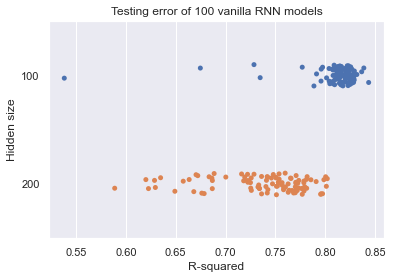

In [44]:
df = pd.DataFrame({"100": r2_scores2, "200": r2_scores})
sns.stripplot(data=df, orient="h")
plt.xlabel("R-squared")
plt.ylabel("Hidden size")
plt.title("Testing error of 100 vanilla RNN models")
plt.savefig('error', dpi=600)

R-squared: 0.9917
Mean Square Error: 0.0237


(0.9917068116984971, 0.023739174)

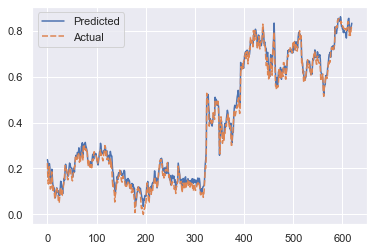

In [28]:
plot(train_prediction, train_actual)
metrics(train_prediction, train_actual)

R-squared: 0.7567
Mean Square Error: 0.0184


(0.756726068222218, 0.01843588)

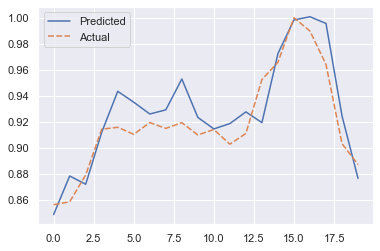

In [29]:
plot(test_prediction, test_actual)
metrics(test_prediction, test_actual)